### Dog Bites- why reporting bias and null data matters in datasets

***

**Purpose:** Originally interested in determining frequency of dog bites for different dog breeds, however, the exploration of this dataset made me instead look into the usefulness of null data with emphasis on three factors. 

    1. Cleaning of public datasets
    2. Determining information from NULL inputs
    3. Importance of funding and educating people on data collection methods

**Data:** Animal bites that occured near Louisville, Kentucky from 1985 to 2017 as reported by the Louisville Metro Department of Public Health and Wellness. Further information on this dataset can be found at https://www.kaggle.com/rtatman/animal-bites

**Input:** 
    One file with 15 columns
    File: Health_AnimalBites.csv

bite_date: The date the bite occurred
SpeciesIDDesc: The species of animal that did the biting
BreedIDDesc: Breed (if known)
GenderIDDesc: Gender (of the animal)
color: color of the animal
vaccination_yrs: how many years had passed since the last vaccination
vaccination_date: the date of the last vaccination
victim_zip: the zipcode of the victim
AdvIssuedYNDesc: whether advice was issued
WhereBittenIDDesc: Where on the body the victim was bitten
quarantine_date: whether the animal was quarantined
DispositionIDDesc: whether the animal was released from quarantine
headsentdate: the date the animal's brain sample was sent to the lab
release_date: the date the animal was released
ResultsIDDesc: results from rabies lab tests
    
**Output:** 

1. Reports of dog bites in the Louisville Metro went from a rarely reported event to a common occurrence in 2008, the same year a animal welfare law went into affect in Kentucky. This suggests that a new emphasis was put on recording these reports, not that the number of bites suddenly increased in the area. 
2. Reports contained spelling mistakes and other inconsistencies between entries. This could be avoided by using drop down menus in the user interface for officers. 
3. 'BreedIDDesc' is often left blank, even after 2008. There are many possibly reasons for this. One is that the dogs are mixed breed. Another is that officers are not breed experts. We cannot expect them to identify all of the dog breeds in the field. A possible solution for both of these problems is to utilize a simple dog breed classifier, a project often used in introductory machine learning courses. The limitation to this method would be that a photo of the dog would need to be taken and data storage costs would increase. 
4. While there are columns for vaccine date and time between vaccine and bite date, the data recorded does not include whether the vaccine was up to date as there is either a 1yr or 3yr version of the rabies vaccine. 


In [1]:
#importing libraries 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
plt.style.use('fivethirtyeight')
from scipy.stats import ttest_ind 
from subprocess import check_output 
import pandas as pd
import folium as folium
from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates
#import matplotlib.dates as mdates
%matplotlib inline


## Data Loading and Exploration 

In [2]:
#Opening the csv and looking at the first few rows of the data- less resource intensive than a full summary 
bites = pd.read_csv("./Desktop/python/Health_AnimalBites.csv")
bites.head()

,bite_date,SpeciesIDDesc,BreedIDDesc,GenderIDDesc,color,vaccination_yrs,vaccination_date,victim_zip,AdvIssuedYNDesc,WhereBittenIDDesc,quarantine_date,DispositionIDDesc,head_sent_date,release_date,ResultsIDDesc
0,1985-05-05 00:00:00,DOG,NaN,FEMALE,LIG. BROWN,1.0,1985-06-20 00:00:00,40229,NO,BODY,1985-05-05 00:00:00,UNKNOWN,NaN,NaN,UNKNOWN
1,1986-02-12 00:00:00,DOG,NaN,UNKNOWN,BRO & BLA,NaN,NaN,40218,NO,BODY,1986-02-12 00:00:00,UNKNOWN,NaN,NaN,UNKNOWN
2,1987-05-07 00:00:00,DOG,NaN,UNKNOWN,NaN,NaN,NaN,40219,NO,BODY,1990-05-07 00:00:00,UNKNOWN,NaN,NaN,UNKNOWN
3,1988-10-02 00:00:00,DOG,NaN,MALE,BLA & BRO,NaN,NaN,NaN,NO,BODY,1990-10-02 00:00:00,UNKNOWN,NaN,NaN,UNKNOWN
4,1989-08-29 00:00:00,DOG,NaN,FEMALE,BLK-WHT,NaN,NaN,NaN,NO,BODY,NaN,UNKNOWN,NaN,NaN,UNKNOWN


Already seeing a few issues with the data:
    -NaN, UNKNOWN, and blank cells are all used for null data 
    -color reporting is not consistent 
        "BRO & BLA" on index row 1 and "BLA & BRO" on index row 3 both representing black and brown 
        BLK and BLA both represeting black

In [3]:
# Take a peak at some of the formats and values 
#bites['GenderIDDesc'].unique()
#bites['vaccination_yrs'].unique()
#bites['victim_zip'].unique()
#bites['AdvIssuedYNDesc'].unique()
bites['WhereBittenIDDesc'].unique()
#bites['DispositionIDDesc'].unique()
#bites['ResultsIDDesc'].unique()


array(['BODY', 'HEAD', nan, 'UNKNOWN'], dtype=object)

In [4]:
# Looking at the date range, documents say it ranges from 1972 to 2017
# A date set to 5013 is causing an error, so I filter it out moving forward
# I will need to filter this further in clean up 
bites.drop(bites[bites['bite_date'] > '2021-01-01'].index, inplace = True)
bites['bite_date'] = pd.to_datetime(bites['bite_date'], format= '%Y-%m-%d')
oldest = bites['bite_date'].min()
newest = bites['bite_date'].max()
print ("Dates range from:", oldest, "to", newest)

Dates range from: 1952-05-28 00:00:00 to 2020-08-08 00:00:00


In [5]:
# What species are represented in the list?
# What could OTHER be?!
bites['SpeciesIDDesc'].value_counts()

DOG        7025
CAT        1566
BAT         237
RACCOON      27
OTHER        11
HORSE         5
FERRET        4
RABBIT        3
SKUNK         1
Name: SpeciesIDDesc, dtype: int64

In [6]:
# Where are the bites occuring 
bites['victim_zip'].value_counts()

40272    375
40291    368
40216    361
40215    356
40214    348
        ... 
40178      1
40025      1
40601      1
46733      1
52349      1
Name: victim_zip, Length: 233, dtype: int64

In [7]:
# Did any of the animals have a positive rabies test?
# Most were not tested
bites['ResultsIDDesc'].value_counts()

UNKNOWN     1240
NEGATIVE     299
POSITIVE       4
Name: ResultsIDDesc, dtype: int64

In [8]:
# What animals were positive
# The majority of the positive animals are bats
bites.loc[bites['ResultsIDDesc'] == 'POSITIVE']

,bite_date,SpeciesIDDesc,BreedIDDesc,GenderIDDesc,color,vaccination_yrs,vaccination_date,victim_zip,AdvIssuedYNDesc,WhereBittenIDDesc,quarantine_date,DispositionIDDesc,head_sent_date,release_date,ResultsIDDesc
1418,2015-05-05,BAT,NaN,NaN,NaN,NaN,NaN,40203,NaN,NaN,NaN,NaN,2015-05-05 00:00:00,NaN,POSITIVE
1502,2017-04-29,DOG,GREAT PYRENEESE,FEMALE,WHITE,NaN,NaN,40210,NaN,NaN,NaN,NaN,2017-05-01 00:00:00,NaN,POSITIVE
1677,NaT,BAT,NaN,NaN,NaN,NaN,NaN,40207,NaN,NaN,NaN,NaN,2016-07-10 00:00:00,NaN,POSITIVE
1678,NaT,BAT,NaN,NaN,NaN,NaN,NaN,40214,NaN,NaN,NaN,NaN,2016-07-29 00:00:00,NaN,POSITIVE


Text(0.5, 0.98, 'Time Since Vaccine in Dogs not Tested for Rabies')

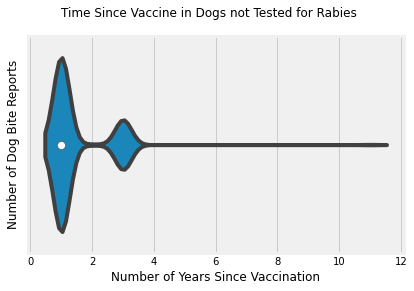

In [9]:
# Were the animals with unknown rabies tests results up to date on their rabies vaccine
nottested = bites.loc[bites['ResultsIDDesc'] == 'UNKNOWN']
nottestedyrs = nottested['vaccination_yrs'].dropna()

fig1, (ax1) = plt.subplots(1, 1)
sns.violinplot(x=nottestedyrs)
plt.xlabel('Number of Years Since Vaccination')
plt.ylabel('Number of Dog Bite Reports')
fig1.suptitle('Time Since Vaccine in Dogs not Tested for Rabies')

### Rabies vaccines are given every 1 year or 3 years depending on the version of the vaccine administered. 
### While it is not clear which dogs received which vaccine, the majority of the dogs with unknown rabies tests were within a year receiving a shot, and thus they were up to date on their rabies vaccine.

In [10]:
# Confirmed deaths of animals after bites
bites['DispositionIDDesc'].value_counts()

RELEASED    910
UNKNOWN     603
KILLED       16
DIED          4
Name: DispositionIDDesc, dtype: int64

In [11]:
# Which animals were killed or died after the bite?
bites.loc[bites['DispositionIDDesc'].isin(['KILLED','DIED'])]

,bite_date,SpeciesIDDesc,BreedIDDesc,GenderIDDesc,color,vaccination_yrs,vaccination_date,victim_zip,AdvIssuedYNDesc,WhereBittenIDDesc,quarantine_date,DispositionIDDesc,head_sent_date,release_date,ResultsIDDesc
1115,2010-12-09,DOG,NaN,UNKNOWN,NaN,NaN,NaN,40214,NO,BODY,2010-12-09 00:00:00,KILLED,2010-12-10 00:00:00,NaN,NEGATIVE
1208,2011-01-16,DOG,PIT BULL,UNKNOWN,BLK-WHITE,NaN,NaN,40216,NO,BODY,2011-01-18 00:00:00,KILLED,2011-01-16 00:00:00,NaN,NEGATIVE
1276,2011-02-16,BAT,NaN,NaN,NaN,NaN,NaN,40258,NO,BODY,NaN,KILLED,2011-02-16 00:00:00,NaN,NEGATIVE
1367,2011-07-06,DOG,NaN,NaN,BLACK,NaN,NaN,40214,NaN,BODY,NaN,KILLED,2011-07-07 00:00:00,NaN,NEGATIVE
1369,2011-09-01,DOG,PIT BULL,MALE,BRN-WHT,NaN,NaN,40213,NO,BODY,NaN,KILLED,2011-09-01 00:00:00,NaN,NEGATIVE
1370,2011-09-08,DOG,NaN,MALE,BLK-BRN,NaN,NaN,40207,NO,BODY,NaN,KILLED,2011-09-08 00:00:00,NaN,NaN
1371,2011-09-09,BAT,NaN,NaN,NaN,NaN,NaN,40205,NO,BODY,NaN,KILLED,2011-09-09 00:00:00,NaN,NaN
1373,2011-10-05,CAT,NaN,MALE,ORANGE,NaN,NaN,40223,NO,BODY,2011-10-05 00:00:00,DIED,2011-10-14 00:00:00,NaN,NEGATIVE
1374,2011-10-12,OTHER,NaN,NaN,NaN,NaN,NaN,40245,NO,BODY,NaN,KILLED,2011-10-14 00:00:00,NaN,NEGATIVE
1375,2011-10-13,CAT,NaN,NaN,BUFF,NaN,NaN,40219,NO,BODY,2011-10-13 00:00:00,KILLED,2011-10-20 00:00:00,NaN,NEGATIVE


In [12]:
# Checking for null data 
print("Null Values in Bite Reports\n", bites.isnull().sum())
print("\nTotal Number of Reports Before Cleaning:", bites['bite_date'].size)

Null Values in Bite Reports
 bite_date             317
SpeciesIDDesc         118
BreedIDDesc          5242
GenderIDDesc         2526
color                2577
vaccination_yrs      5262
vaccination_date     4885
victim_zip           1836
AdvIssuedYNDesc      6433
WhereBittenIDDesc     616
quarantine_date      6978
DispositionIDDesc    7464
head_sent_date       8602
release_date         7553
ResultsIDDesc        7454
dtype: int64

Total Number of Reports Before Cleaning: 8997


## Animal Bites Over Time

In [13]:
# Delete the dates outside of the timeframe stated on documentation 
bites['bite_date'] = pd.to_datetime(bites['bite_date'], format= '%Y-%m-%d')
bites.sort_values(by=['bite_date'])
bites = bites.loc[(bites['bite_date'] < '2017-01-01')
                     & (bites['bite_date'] > '1985-01-01')]

# Drop reports without a date 
bites = bites.dropna(subset=['bite_date'])

# Confirm there is no null data
print(bites['bite_date'].isnull().sum())

0


Text(0.5, 1.0, 'Dates of Bite Reports')

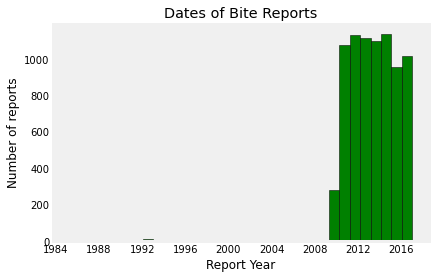

In [14]:
# Plotting the dates of the dog bites 
# 33 bins are roughly the number of years in the dataset
bites['bite_date'].hist(grid=False, bins=33, color='green',edgecolor='black')
plt.xlabel('Report Year')
plt.ylabel('Number of reports')
plt.title('Dates of Bite Reports')

### The number of reports filed jumps dramatically in 2009.  
### Kentucky implemented new laws on animal welfare in 2008, possibly explaining the increase in formal reporting of animal bites in the area. 

Text(0.5, 1.0, 'Dates of Bite Reports')

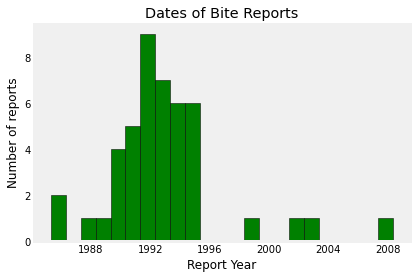

In [15]:
# The five years before the law there were zero bites reports
prior2008 = bites.loc[(bites['bite_date'] < '2008-12-31')
                     & (bites['bite_date'] > '1985-01-01')]

prior2008['bite_date'].hist(grid=False, bins=23, color='green',edgecolor='black', range= (5600,14000))
plt.xlabel('Report Year')
plt.ylabel('Number of reports')
plt.title('Dates of Bite Reports')

# Dog Bites

In [16]:
# Creates a dataframe of only the entries with DOG as the species 
dogbites = bites.loc[bites['SpeciesIDDesc'] == 'DOG', :].copy()
print("Null Values in Bite Reports of only dogs\n", dogbites.isnull().sum())

Null Values in Bite Reports of only dogs
 bite_date               0
SpeciesIDDesc           0
BreedIDDesc          3072
GenderIDDesc         1451
color                1521
vaccination_yrs      3373
vaccination_date     3086
victim_zip           1297
AdvIssuedYNDesc      4306
WhereBittenIDDesc     209
quarantine_date      4659
DispositionIDDesc    5046
head_sent_date       6180
release_date         5379
ResultsIDDesc        5247
dtype: int64


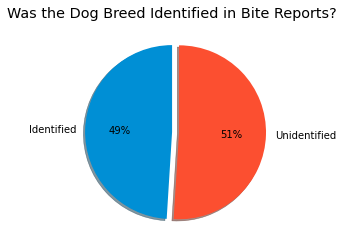

In [17]:
# Next we clean up Breed ID
Percent_BreedNull =  ((dogbites['BreedIDDesc'].isnull().sum()) / (dogbites['bite_date'].size))
Percent_BreedNull

labels = 'Identified', 'Unidentified'
sizes = [Percent_BreedNull, (1- Percent_BreedNull)] 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=(0,0.08), labels=labels, autopct='%1.0f%%', shadow=True, startangle=90)
ax1.set_title('Was the Dog Breed Identified in Bite Reports?')
plt.show()

Over half of reports do not identify the dog breed.
This loss of data makes the reports unsuitable for identifying if breed influences bites. 
Possible reasons for this lack of data:

1. Police/victims are not familiar with dog breeds. 
2. Data entry of bite reports has changed over the years to include this data point  

We can test the second reason by seeing if the percent of reports with dog breed identified has increased over the years

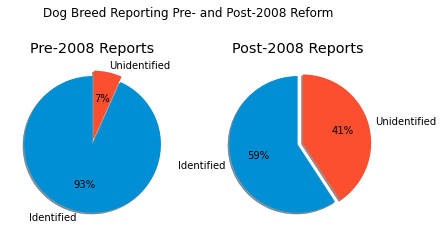

In [18]:
# Separating dataset by pre and post 2008 regulation and determining percent of reports including breed
prior2008 = bites.loc[(bites['bite_date'] < '2008-12-31')
                     & (bites['bite_date'] > '1985-01-01')]
prior2008['BreedIDDesc'].value_counts()
prior2008_BreedNull =  ((prior2008['BreedIDDesc'].isnull().sum()) / (prior2008['bite_date'].size))

post2008 = bites.loc[(bites['bite_date'] < '2017-12-31')
                     & (bites['bite_date'] > '2008-12-31')]
post2008['BreedIDDesc'].value_counts()
post2008_BreedNull =  ((post2008['BreedIDDesc'].isnull().sum()) / (post2008['bite_date'].size))

# Graphing pre and post 2008 Breed ID percetages 
labels = 'Identified', 'Unidentified'
presizes = [prior2008_BreedNull, (1- prior2008_BreedNull)]
postsizes = [post2008_BreedNull, (1- post2008_BreedNull)]

fig2, (ax1, ax2) = plt.subplots(1,2)
ax1.pie(presizes, explode=(0,0.08), labels=labels, autopct='%1.0f%%', shadow=True, startangle=90)
ax1.set_title('Pre-2008 Reports')
ax2.pie(postsizes, explode=(0,0.08), labels=labels, autopct='%1.0f%%', shadow=True, startangle=90)
ax2.set_title('Post-2008 Reports')
fig2.suptitle('Dog Breed Reporting Pre- and Post-2008 Reform')
plt.show()

### While the percentage of reports including breed ID increased after legislation, most of the reports still did not include this data. 

<AxesSubplot:xlabel='BreedIDDesc'>

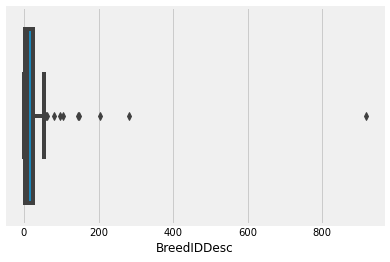

In [19]:
#Number of bite reports in each breed
dogs_with_breed = dogbites.dropna(subset = ['BreedIDDesc'])
bitesperbreed= dogs_with_breed['BreedIDDesc'].value_counts()
sns.boxplot(x= bitesperbreed)

In [20]:
bitecounts= dogs_with_breed['BreedIDDesc'].value_counts()
print("Distribution of dog bites across breeds:\n", bitecounts.describe(), "\n")
print("Top 15 Breeds with most bites:\n", bitecounts.head(n=15))


Distribution of dog bites across breeds:
 count     99.000000
mean      32.282828
std       99.134833
min        1.000000
25%        3.000000
50%        8.000000
75%       24.500000
max      917.000000
Name: BreedIDDesc, dtype: float64 

Top 15 Breeds with most bites:
 PIT BULL             917
GERM SHEPHERD        282
LABRADOR RETRIV      205
BOXER                148
CHICHAUHUA           144
SHIH TZU             105
BEAGLE                96
ROTTWEILER            80
AAUST. TERR.          62
DACHSHUND             58
GOLD RETRIEVER        53
POODLE                45
YORKSHIRE TERRIER     42
BORDER COLLIE         42
CHOW CHOW             39
Name: BreedIDDesc, dtype: int64


### While german shepherds and pit bulls have significantly more reports than other breeds, it must be remembered that this represents under half of the reports. 

However, the BreedID could be represented in another way that would not require much as much specific breed knowledge.

The breed ID needs to be cleaned up- EXAMPLES: 
poodle and Stan poodle
weiner dog, DOTSON, and Dachshund 
english bulldog, bulldog, and american bulldog 
OTHER
BORDER COLLIE M
SAINT BERNARD AND ST BERNARD 
BOX TERRIER and FOX TERRIER
ALASK. MALAMUTE and MALAMUTE

Instead of correcting each term individually, I create generalized categories. For more information on these categories please see Parker et al 2017 on dog breed genetics and historical lineages. 

In [21]:
#Found the unique breeds and sorted them into general categories based on genetic relatedness (Parker et al, 2017)
Bully = bitecounts.loc[['BOXER','PIT BULL','AMER. BULL DOG','BULL DOG', 'MASTIF','BULLMASTIFF','GREAT DANE','AM BULLDOG','DOBERMAN','ENGLISH BULLDOG','CANE CORSO','ENG. MASTIFF','ROTTWEILER']]
Companion = bitecounts.loc[['TOY POODLE',  'SHIH TZU','CHICHAUHUA','POMERANIAN', 'MALTASE','BOSTON TERRIER','BICHON FRISE','PUG','FRENCH BULLDOG','PEKINGESE','LHASA APSO','HAVANESE','COCKAPOO','BICHON FRESE','AM. ESKIMO','STAN POODLE','POODLE','YORKSHIRE TERRIER']]
Herding = bitecounts.loc[['BORDER COLLIE','BORDER COLLIE M','SHEEP DOG','GREAT PYRENEESE','CORGI','WELSH CORGI','SHELTIE','OLD ENG SHP DOG','BEARDED COLLIE','RED HEELER','BLUE HEELER','HEELER','COLLIE','ENGLISH SHEPARD','CATTLE DOG','BRIARD','GERM SHEPHERD']]
HuntingHoundTer = bitecounts.loc[['BLOOD HOUND','WEINER DOG','DACHSHUND','DOTSON','BEAGLE','BASSET HOUND','BOX TERRIER','COON HOUND','FOX TERRIER','FOX TERRIER MIX','CATAHOULA','GREYHOUND']]
HuntingRetrSpan= bitecounts.loc[['ENGLISH SETTER', 'IRISH SETTER','BRITNEY SPANIEL','COCKER SPAINEL','GOLD RETRIEVER','LABRADOR RETRIV','GOLDEN LAB','IRISH SPANIEL','BLACK LAB','CHOCOLATE LAB.','WEIMARANER','DALMATIAN']]
Mountain = bitecounts.loc[['SAINT BERNARD','ST BERNARD','BERNESEN MT.','NEW FOUNDLAND','PYRENES','BOUVIER']]
Pacific= bitecounts.loc[['HUSKY','SIBERAN HUSKY','SAMOYED','SPITZ','AKITA','CHOW CHOW','SHAR-PEI','BASANJI','BESINJI', 'ALASK. MALAMUTE','MALAMUTE']]
Ratters = bitecounts.loc[['AAUST. TERR.','WESTIE','MIN PIN','SCHNAUZER','RAT TERRIER','TOY FOX TERRIER','SCOTTISH TER.', 'LAKELAND TER.']]
Other = bitecounts.loc[['OTHER']]

In [22]:
DogType = ['Bully', 'Companion', 'Herding', 'HuntingHoundTer', 'HuntingRetrSpan', 'Mountain', 'Pacific', 'Ratters', 'Other']
TypeCount = [Bully.sum(), Companion.sum(), Herding.sum(), HuntingHoundTer.sum(), HuntingRetrSpan.sum(), Mountain.sum(), Pacific.sum(), Ratters.sum(), Other.sum()]

bitesbytype = pd.DataFrame(list(zip(DogType, TypeCount)),
               columns =['Dog Type', 'Bite Count'])
bitesbytype

,Dog Type,Bite Count
0,Bully,1375
1,Companion,480
2,Herding,418
3,HuntingHoundTer,231
4,HuntingRetrSpan,336
5,Mountain,21
6,Pacific,143
7,Ratters,158
8,Other,31


# Dog Color and Bite Counts

This section is still a work in progress and requires more than regex commands. 

In [23]:
dogs_with_breed['color'].unique().tolist()

['BROWN/BLAC',
 'RED',
 'BLK-WHITE',
 'BLACK',
 'BEIGE-WHT',
 'WHITE-TAN',
 'TAN',
 'BLACK-WHIT',
 nan,
 'BRN-BRINDL',
 'WHITE',
 'GRAY',
 'FAWN',
 'TRI',
 'BLACK-TAN',
 'TAN-WHITE',
 'YELLOW',
 'BLK-BROWN',
 'CHOCOLATE',
 'LT. GOLDEN',
 'BLK-WHT',
 'WHITE-BRN',
 'BROWN-BLK',
 'GRAY-WHT',
 'BRINDLE',
 'CREAM',
 'BLK-BRINDL',
 'SANDY',
 'BRN-BLK',
 'BRINDLE-WH',
 'BRN-WHT',
 'BRN-WHITE',
 'BLACK/WHIT',
 'GRAY/WHITE',
 'BROWN',
 'GOLDEN',
 'TAN BLK',
 'BLK WHTE',
 'BRN WHT',
 'BLUE WHIT',
 'WHT BLK',
 'WHT BRN',
 'WHT TAN',
 'BLK WHT',
 'BLK',
 'TAN-SILVER',
 'BLUE-WHT',
 'BLK-TAN',
 'TAN-WHT',
 'GRAY-BLK',
 'GREY',
 'BEIGE',
 'WHT-BLK',
 'RED-WHT',
 'BLK-GRAY',
 'BLK-BRN',
 'RED-BRN',
 'CHO.-TAN',
 'BLK-GOLD',
 'TANISH',
 'TAN-BLK',
 'BL-BRINDLE',
 'GRAY-BLUE',
 'WHT-BRN',
 'BLACK-WHT',
 'BLONDE',
 'BLACK & WH',
 'BROWN-WHT',
 'GRAY-WHITE',
 'FAWN-WHT',
 'WHT-TAN',
 'WHITE-BLK',
 'TAN-BLACK',
 'REDDISH BR',
 'BLALCK',
 'GRAY/BROWN',
 'BLACK/GRAY',
 'BLK/BRN',
 'BRN-BEIGE',
 'TAN & WHIT'

In [ ]:
# First get rid of special characters
# next get rid of color variants 
# keeps caps lock consistent with the rest of the dataset
#'BLK' : 'BLACK' , 'BLCK' : 'BLACK', 'BLAK' : 'BLACK',  'BLAC\b' : 'BLACK ', 'BLA\b' : 'BLACK',   'BLK' : 'BLACK' , 
#'BRN' : 'BROWN' , 'BRO\b' : 'BROWN ', 
#'WHT' : 'WHITE' ,  'WHIT\b' : 'WHITE' , 'WH\b' : 'WHITE',
#' \b' : '',

dogs_with_breed.replace({'color' : { '\/' : ' ', '\&' : ' ', '\-' : ' ', '\.' : '', 
            'LT\b' : '', 'LIGHT' : '' , 'LGT': '', 
            'TAN' : 'BROWN', 'FAWN' : 'BROWN', 'RED' : 'BROWN', 'GOLDEN' : 'BROWN', 'SANDY' : 'BROWN',
            'WHITE, BR,BL' : 'TRI', 
            
            'BEIGE' : 'WHITE' , 'CREAM' : 'WHITE' ,
            '\bW' : 'WHITE' ,
            '\bBR' : 'BROWN' ,               
            '\bBL' : 'BLACK',
            '\bO' : 'BROWN',
            'BROWN BLACK' : 'BLACK BROWN'
                                                                 
                                                   
                         }}, regex=True, inplace = True)
dogs_with_breed.head()


In [ ]:
dogs_with_breed.replace({'color' : {
        
            '\bW' : 'WHITE' ,
            '\bBR' : 'BROWN' ,               
            '\bBL' : 'BLACK',
            '\bO' : 'BROWN'
                                                                                                                      
                         }}, regex=True, inplace = True)
dogs_with_breed.head()
